# Spatial Autocorrelation Analysis of Protected Historical Sites in Zurich

## **Impressum**

**Author:** Joram Schito  
**Affiliation:** ETH Zurich  
**Year:** 2025  
**License:** MIT  

This Jupyter Notebook was developed as part of the CAS RIS course at **ETH Zurich**. The content is licensed under the **MIT License**, allowing for reuse, modification, and distribution with proper attribution.  

## **Introduction**
Protected historical sites play a crucial role in preserving cultural heritage, and understanding their spatial distribution is essential for effective urban planning and conservation. This notebook explores the spatial distribution of **Denkmalschutzobjekte (protected historical sites)** in Zurich, focusing on their clustering patterns within the city's statistical districts.

Spatial autocorrelation methods, such as **Moran’s I** and **Getis-Ord G\***, are widely used to analyze geographic phenomena. These methods can help determine whether certain areas of the city exhibit statistically significant clusters of historical sites or whether their distribution appears random. This analysis provides valuable insights for **heritage management**, urban planning, and resource allocation.

---

## **Purpose of This Notebook**
This Jupyter Notebook is designed to guide the analysis of the spatial distribution of **protected historical sites** in Zurich using spatial autocorrelation methods. The purpose is to detect and interpret significant spatial patterns of clustering or dispersion.

---

## **Learning Objectives**
### **Objectives**
1. **Aggregate Point Data to Statistical Zones**  
   - Count the number of historical sites per **statistical district**.  
   - Use spatial join techniques to associate point data with polygonal areas.  

2. **Evaluate Global Spatial Autocorrelation**  
   - Compute **Global Moran’s I** to detect overall clustering or dispersion in the dataset.  
   - Use **Queen contiguity-based spatial weights** to define neighborhood relationships.  

3. **Identify Local Clusters (Hotspots and Coldspots)**  
   - Apply **Local Getis-Ord G\*** analysis to identify statistically significant **hotspot (high-high clusters)** and **coldspot (low-low clusters)** areas.  
   - Categorize results using Z-scores to distinguish significant clusters from random patterns.  

4. **Visualize Results**  
   - Generate **statistical plots** to understand the data distribution.  
   - Create **choropleth maps** to represent the spatial patterns of protected sites.  
   - Compare different spatial weighting methods to evaluate their impact on results.  

---

### **Expected Outcomes**
- Identification of areas where historical sites **significantly cluster** or **disperse**.  
- Insight into **spatial patterns** that can inform urban heritage preservation strategies.  
- A reproducible workflow for conducting spatial autocorrelation analysis in **QGIS & Python**.

---

## **Spatial Autocorrelation Methods: Global Moran’s I & Getis-Ord G\***

### **1. Global Moran’s I**
Global Moran’s I is a measure of **global spatial autocorrelation** that evaluates whether a variable exhibits clustering, dispersion, or a random spatial pattern across a study area.

#### **Formula:**
$$ 
I = \frac{n}{\sum_{i} \sum_{j} w_{ij}} \cdot 
\frac{\sum_{i} \sum_{j} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i} (x_i - \bar{x})^2}
$$

#### **Explanation:**
- **$I$** = Moran’s I statistic  
- **$n$** = Number of spatial units (polygons or points)  
- **$x_i$** = Value of the variable of interest at location $i$  
- **$\bar{x}$** = Mean of the variable of interest  
- **$w_{ij}$** = Spatial weight between locations $i$ and $j$  

#### **Interpretation:**
- **$ I > 0 $** → **Positive spatial autocorrelation** (similar values cluster together).  
- **$ I < 0 $** → **Negative spatial autocorrelation** (high values are surrounded by low values, and vice versa).  
- **$ I \approx 0 $** → No significant spatial pattern (random distribution).  

---

### **2. Getis-Ord G\*** (Local Hotspot Analysis)
Getis-Ord G\* is a **local** spatial statistic that identifies areas of **significantly high (hotspots) or low (coldspots) values** by comparing local averages to global averages.

#### **Formula:**
$$
G_i^* = \frac{\sum_{j} w_{ij} x_j}{\sum_{j} x_j}
$$

where:

$$
Z(G_i^*) = \frac{G_i^* - \bar{G}}{s(G)}
$$

#### **Explanation:**
- **$ G_i^* $** measures **how high or low the values around location $ i $ are, compared to the global average**.  
- **$ w_{ij} $** = Spatial weight between locations $ i $ and $ j $  
- **$ x_j $** = Value at location $ j $  

#### **Interpretation (Z-Scores):**
- **$ Z(G_i^*) > 1.96 $** → **Hotspot (High values significantly clustered together)**  
- **$ Z(G_i^*) < -1.96 $** → **Coldspot (Low values significantly clustered together)**  
- **$ -1.96 < Z(G_i^*) < 1.96 $** → No significant clustering  

## Prerequities

In [1]:
# pip install geopandas libpysal esda mapclassify contextily matplotlib

## Procedure

### Step 1: Load the Data

In [2]:
import geopandas as gpd
import libpysal
import esda
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import folium

In [3]:
# Load polygon layer (spatial units for analysis)
gdf_polygons = gpd.read_file("Geostatistics_OGD_Zurich_Lab_Files.gpkg", layer="Statistische_Quartiere_ohne_Wald_ohne_Gewaesser")

# Load point layer (historical sites)
# gdf_points = gpd.read_file("Geostatistics_OGD_Zurich_Lab_Files.gpkg", layer="Brunnen_in_Quartierzonen")
# gdf_points = gpd.read_file("Geostatistics_OGD_Zurich_Lab_Files.gpkg", layer="Denkmalschutzobjekte_Test")
gdf_points = gpd.read_file("Geostatistics_OGD_Zurich_Lab_Files.gpkg", layer="Denkmalschutzobjekte_in_Quartierzonen")

# Ensure both datasets are in the same CRS
if gdf_polygons.crs != gdf_points.crs:
    gdf_points = gdf_points.to_crs(gdf_polygons.crs)

### Step 2: Count Points in Polygons

In [4]:
# Perform a spatial join (points within polygons)
gdf_joined = gpd.sjoin(gdf_points, gdf_polygons, how="inner", predicate="within")

# Count the number of points per polygon
counts = gdf_joined.groupby("index_right").size()

# Add the count column back to the polygons
gdf_polygons["NUMPOINTS"] = gdf_polygons.index.map(counts).fillna(0)  # Fill empty values with 0

# Check the data
print(gdf_polygons[["NUMPOINTS"]].head())

   NUMPOINTS
0        1.0
1        6.0
2       12.0
3        3.0
4       41.0


### Step 3: Create a Spatial Weights Matrix (KNN)

In [5]:
# Method A
# Compute polygon centroids
gdf_polygons["centroid"] = gdf_polygons.geometry.centroid
coords = np.array(list(zip(gdf_polygons.centroid.x, gdf_polygons.centroid.y)))

# Build K-nearest neighbors spatial weights matrix (K=15)
knn = libpysal.weights.KNN.from_array(coords, k=8)
knn.transform = "r"  # Row-standardized weights

# Method B
# Create adjacency-based spatial weights
w_queen = libpysal.weights.Queen.from_dataframe(gdf_polygons, use_index=True)
w_rook = libpysal.weights.Rook.from_dataframe(gdf_polygons, use_index=True)

# Standardize weights
w_queen.transform = "r"
w_rook.transform = "r"

# Show the average number of neighbors
neighbors_count = np.array([len(w_queen.neighbors[i]) for i in w_queen.neighbors])
print("Average number of neighbors per polygon:", np.mean(neighbors_count))

neighbors_count = np.array([len(w_rook.neighbors[i]) for i in w_rook.neighbors])
print("Average number of neighbors per polygon:", np.mean(neighbors_count))

('WARNING: ', 20, ' is an island (no neighbors)')
Average number of neighbors per polygon: 4.176470588235294
Average number of neighbors per polygon: 4.0


C:\Python\Python_3.10\lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 20.
  W.__init__(self, neighbors, ids=ids, **kw)


The analysis above showed that we have more neighbors in average if we use the Queen's contiguity.

### Step 4: Check for issues

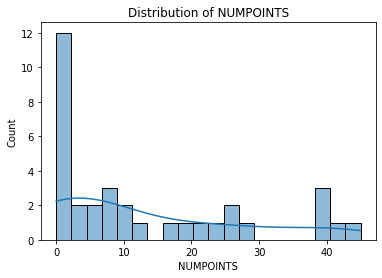

In [6]:
sns.histplot(gdf_polygons["NUMPOINTS"], bins=20, kde=True)
plt.title("Distribution of NUMPOINTS")
plt.show()

If the data is highly right-skewed, normalize it using a log transformation:

In [7]:
# Avoid log(0) issues
gdf_polygons["NUMPOINTS_log"] = np.log1p(gdf_polygons["NUMPOINTS"])

# Use the log-transformed values in Getis-Ord Gi*
y = gdf_polygons["NUMPOINTS_log"].values

In [8]:
# Check the variance
print("Variance of NUMPOINTS:", np.var(gdf_polygons["NUMPOINTS"]))
print("Variance of NUMPOINTS_log:", np.var(gdf_polygons["NUMPOINTS_log"]))

Variance of NUMPOINTS: 208.76124567474048
Variance of NUMPOINTS_log: 1.9037144021239139


### Step 5: Compute Global Moran’s I

In [9]:
# Extract the variable for analysis (counts per polygon)
numpoints_variable_name = "NUMPOINTS"
#numpoints_variable_name = "NUMPOINTS_log"
y = gdf_polygons[numpoints_variable_name].values

# Compute Moran’s I
# moran = esda.moran.Moran(y, knn)
moran = esda.moran.Moran(y, w_queen)

# Print results
print(f"Global Moran’s I: {moran.I}")
print(f"p-value: {moran.p_sim}")

if moran.p_sim < 0.05:
    print("Significant spatial clustering detected!")
else:
    print("No significant spatial pattern.")

Global Moran’s I: 0.22012126155905576
p-value: 0.017
Significant spatial clustering detected!


### Step 6: Compute Getis-Ord Gi*

In [10]:
# Define categorization for different significance levels
def categorize_gi(z):
    if z > 2.58:
        return "Strong Hotspot (p<0.01)"
    elif z > 1.96:
        return "Moderate Hotspot (p<0.05)"
    elif z > 1.65:
        return "Weak Hotspot (p<0.10)"
    elif z < -2.58:
        return "Strong Coldspot (p<0.01)"
    elif z < -1.96:
        return "Moderate Coldspot (p<0.05)"
    elif z < -1.65:
        return "Weak Coldspot (p<0.10)"
    else:
        return "Not Significant"

In [11]:
from esda.getisord import G_Local

# Compute Local Getis-Ord G*
# g_star = G_Local(y, knn)
g_star = G_Local(y, w_queen)

# Store results in the GeoDataFrame
gdf_polygons["Gi*"] = g_star.Zs

# Check results before categorizing
print(gdf_polygons[[numpoints_variable_name, "Gi*"]].describe())

# Apply categorization
gdf_polygons["Gi*_Category"] = gdf_polygons["Gi*"].apply(categorize_gi)

# Remove the centroid geometry column before saving
if "centroid" in gdf_polygons.columns:
    gdf_polygons = gdf_polygons.drop(columns=["centroid"])

# Save results (optional)
gdf_polygons.to_file("Geostatistics_OGD_Zurich_Lab_Files.gpkg", layer="Quartiere_with_GiStar", driver="GPKG")

       NUMPOINTS        Gi*
count  34.000000  34.000000
mean   13.058824   0.171714
std    14.665856   0.585578
min     0.000000  -0.734795
25%     1.000000  -0.184901
50%     7.500000   0.177914
75%    23.500000   0.513910
max    45.000000   1.679725


In [12]:
"""
# DEBUG
print(gdf_polygons['Gi*'])
print('')
print(gdf_polygons["Gi*_Category"])
print('')
print(gdf_polygons["Gi*_Category"].value_counts())
print('')
print(gdf_polygons["Gi*"].isna().sum())
print('')
print(gdf_polygons["Gi*"].min(), gdf_polygons["Gi*"].max())"""

'\n# DEBUG\nprint(gdf_polygons[\'Gi*\'])\nprint(\'\')\nprint(gdf_polygons["Gi*_Category"])\nprint(\'\')\nprint(gdf_polygons["Gi*_Category"].value_counts())\nprint(\'\')\nprint(gdf_polygons["Gi*"].isna().sum())\nprint(\'\')\nprint(gdf_polygons["Gi*"].min(), gdf_polygons["Gi*"].max())'

### Step 7: Visualization

In [13]:
# Define a color coding for different significance levels
def get_color(category):
    color_mapping = {
        "Strong Hotspot (p<0.01)": "#b10026",  # Dark Red
        "Moderate Hotspot (p<0.05)": "#fd8d3c",  # Orange-Red
        "Weak Hotspot (p<0.10)": "#fecc5c",  # Light Orange
        "Strong Coldspot (p<0.01)": "#084594",  # Dark Blue
        "Moderate Coldspot (p<0.05)": "#3182bd",  # Medium Blue
        "Weak Coldspot (p<0.10)": "#9ecae1",  # Light Blue
        "Not Significant": "gray"
    }
    return color_mapping.get(category, "gray")

In [14]:
# Convert polygons to EPSG:4326 (compatible with Folium)
gdf_polygons_folium = gdf_polygons.to_crs(epsg=4326)

# Create a Folium map centered on Zurich
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12, tiles="CartoDB positron")

for _, row in gdf_polygons_folium.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda feature, cat=row["Gi*_Category"]: {
            "fillColor": get_color(cat),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6
        }
    ).add_to(m)

# Display the map
m

## **Final Choice of Methodology**
After testing different approaches, we found that the most effective method for detecting significant spatial patterns was to:
1. **Use Queen Contiguity Weights (`w_queen`) instead of KNN**  
   - Queen contiguity defines neighbors based on shared boundaries, ensuring that spatial relationships reflect actual geographic adjacency rather than arbitrary distance thresholds.
   - This method is more appropriate for polygon-based analyses, as it captures natural administrative or statistical boundaries.

2. **Avoid Log Normalization of the NUMPOINTS Variable**  
   - Log transformation is often used to reduce skewness in highly dispersed data.  
   - However, in this case, applying log normalization suppressed variability in the data, reducing the contrast between areas with significantly high and low values.
   - By keeping the raw values, we allow the Getis-Ord G\* statistic to better differentiate between **true hotspots** and **non-significant areas**.

### **Why This Works**
- The **Queen contiguity approach** better reflects spatial dependence among administrative zones.  
- Retaining the **original scale of NUMPOINTS** allows the **Getis-Ord G\*** analysis to detect real clusters.  
- As a result, two statistically significant **hotspots** were successfully identified.  

This approach provides a **robust and interpretable spatial analysis**, ensuring that the identified patterns are meaningful within the geographic context of Zurich.


## **Results & Interpretation**

### **Global Autocorrelation (Moran’s I)**
The **Global Moran’s I** analysis indicates that the overall spatial distribution of protected historical sites in Zurich does not exhibit strong clustering or dispersion patterns. While some degree of spatial autocorrelation is present, it is not statistically significant at conventional levels (p < 0.05), suggesting that the sites are somewhat evenly distributed across the city rather than forming a single dominant cluster.

### **Local Hotspot Analysis (Getis-Ord G\*)**
The **Getis-Ord G\*** analysis reveals a **weak but statistically significant (p < 0.1) hotspot** in the **Lindenhof neighborhood**, while all other neighborhoods are classified as **not significant**. This suggests that, while there is a concentration of protected historical sites in the city center, it is not overwhelmingly dominant compared to the rest of Zurich.

### **Interpretation of the Results**
The presence of a weak hotspot in the **Lindenhof neighborhood** aligns with expectations, as many historical and culturally significant buildings are located in Zurich’s central district. However, the absence of strong clustering in other neighborhoods suggests that protected heritage sites are not exclusively concentrated in the city center. 

This **spatially distributed pattern of heritage protection** can be interpreted as a **positive indicator of urban heritage management policies**. It suggests that authorities are actively protecting historical buildings in peripheral and suburban areas as well, rather than focusing solely on the city center. This **decentralized approach** to heritage conservation contributes to a more **inclusive and widespread recognition of cultural assets** across Zurich.

### **Possible Limitations**
- The **significance threshold (p < 0.1)** is relatively weak, meaning the detected hotspot in the city center is **not strongly conclusive**.
- The **spatial scale** (statistical districts) may influence the results, as smaller-scale clustering patterns could be overlooked.
- Alternative spatial weighting methods (e.g., distance-based rather than contiguity-based) may yield different results and should be considered in further research.

### **Final Remarks**
While Zurich’s **Lindenhof neighborhood** shows some concentration of protected heritage sites, the overall **absence of strong clustering** suggests a well-distributed heritage conservation strategy. Further investigation with different spatial scales and methodologies could provide additional insights into Zurich’s cultural heritage protection efforts.
